In [10]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt

def create_dataset_torch(
    dataset_name, 
    dataset_dir, 
    batch_size=64, 
    test_size=0.2, 
    random_state=42
):
    if dataset_name == 'CIFAR10':
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, 
                                              download=True, transform=transform)
    elif dataset_name == 'MNIST':
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True,
                                            download=True, transform=transform)
    else:
        raise ValueError(f"DataSet Not Supported: {dataset_name}")
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=True, drop_last=True)
    
    images, labels = next(iter(dataloader))
    
    images = images.reshape(batch_size, -1).numpy()
    labels = labels.numpy()
    
    # 分割训练集(8)和测试集(2)
    X_train, X_test, Y_train, Y_test = train_test_split(
        images, labels, test_size=test_size, random_state=random_state
    )

    print(f"The {dataset_name} X_train size is: {X_train.shape}")
    print(f"The {dataset_name} X_test size is: {X_test.shape}")
    print(f"The {dataset_name} Y_train size is: {Y_train.shape}")
    print(f"The {dataset_name} Y_test size is: {Y_test.shape}")

    return X_train, X_test, Y_train, Y_test

In [11]:
def visualize(X, y, y_pred, title=None):

    pca = PCA(n_components=2)
    X_dim_reduction = pca.fit_transform(X)
    plt.figure(figsize=(10, 12))

    def get_color(y):
        color_dict = {-1: '#FFFFFF', 0: '#FF0000', 1: '#FFA500', 2: '#FFFF00', 3: '#008000', 
                      4: '#FF00FF', 5: '#0000FF', 6: '#00FFFF', 7: '#A52A2A', 8: '#800080', 
                      9: '#7FFFD4'}

        color = []
        for i in range(y.shape[0]):
            color.append(color_dict.get(y[i].item(), 'olive'))
        return color
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].set_title('Original Data')
    axs[0].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y), edgecolors='black')

    axs[1].set_title('Cluster Result')
    axs[1].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y_pred), edgecolors='black')

    plt.show()

In [ ]:
class MyKMeans:
    """My Handmade KMeans Implementation"""
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.labels_ = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.n_iter_ = 0

    def _init_centroids(self, X):
        np.random.seed(self.random_state)
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]

    def fit(self, X):
        n_samples, n_features = X.shape
        self.cluster_centers_ = self._init_centroids(X)
        prev_inertia = float('inf')

        for i in range(self.max_iter):
            distances = np.zeros((n_samples, self.n_clusters))
            for j in range(self.n_clusters):
                # 计算每个样本到每个聚类中心的距离
                distances[:, j] = np.sum((X - self.cluster_centers_[j])**2, axis=1)

            self.labels_ = np.argmin(distances, axis=1)

            # 更新聚类中心
            new_centroids = np.zeros((self.n_clusters, n_features))
            for j in range(self.n_clusters):
                if np.sum(self.labels_ == j) > 0:
                    new_centroids[j] = np.mean(X[self.labels_ == j], axis=0)
                else:
                    new_centroids[j] = X[np.random.choice(n_samples)]

            self.cluster_centers_ = new_centroids

            # 计算当前的惯性(inertia)，即所有点到其聚类中心的距离平方和
            inertia = 0
            for j in range(self.n_clusters):
                cluster_points = X[self.labels_ == j]
                if len(cluster_points) > 0:
                    inertia += np.sum((cluster_points - self.cluster_centers_[j])**2)

            self.inertia_ = inertia
            self.n_iter_ += 1

            if abs(prev_inertia - inertia) < self.tol:
                break

            prev_inertia = inertia

        return self

In [13]:
class NoTransform:
    def __init__(self, n_components = 2):
        pass
    def fit_transform(self, x):
        return x

In [14]:
def save_numpy(X_train, X_test, Y_train, Y_test):
    np.savetxt('X_train.csv', X_train, delimiter=',')
    np.savetxt('X_test.csv', X_test, delimiter=',')
    np.savetxt('Y_train.csv', Y_train, delimiter=',')
    np.savetxt('Y_test.csv', Y_test, delimiter=',')

def load_numpy():
    X_train = np.loadtxt('X_train.csv', delimiter=',')
    X_test = np.loadtxt('X_test.csv', delimiter=',')
    Y_train = np.loadtxt('Y_train.csv', delimiter=',')
    Y_test = np.loadtxt('Y_test.csv', delimiter=',')
    return X_train, X_test, Y_train, Y_test

In [15]:
X_train, X_test, Y_train, Y_test = create_dataset_torch('CIFAR10', '../../datasets/cifar10/train/', batch_size=10000, test_size=0.2, random_state=42)

Files already downloaded and verified
The CIFAR10 X_train size is: (8000, 3072)
The CIFAR10 X_test size is: (2000, 3072)
The CIFAR10 Y_train size is: (8000,)
The CIFAR10 Y_test size is: (2000,)


In [16]:
save_numpy(X_train, X_test, Y_train, Y_test)

In [17]:
X_train, X_test, Y_train, Y_test = load_numpy()

In [18]:
Func = {
    'KMeans': MyKMeans,
    'DBSCAN': DBSCAN,
    'AC': AgglomerativeClustering
}
Reduction = {
    'tsne': TSNE,
    'pca': PCA,
    'none': NoTransform
}

def Train_Result(func, reduction, X_train, Y_train, n_components, **kwargs):
    start_execution = time.time()
    reduction_now = Reduction[reduction](n_components = n_components)
    x_lower = reduction_now.fit_transform(X_train)
    func_now = Func[func](**kwargs)

    start_train = time.time()
    func_now.fit(x_lower)
    end_train = time.time()
    y_pred = func_now.labels_

    D = max(int(Y_train.max()), int(y_pred.max())) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(len(y_pred)):
        w[int(y_pred[i]), int(Y_train[i])] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    col_ind = np.asarray(col_ind)
    y_pred = col_ind[[y_pred[i] for i in range(len(y_pred))]]

    visualize(X_train, Y_train, y_pred, title=func)
    end_execution = time.time()

    print("Train Time: %.6f s" % (end_train - start_train))
    print("Execution Time: %.6f s" % (end_execution - start_execution))
    print('')
    print('Accuracy:', accuracy_score(Y_train, y_pred))
    print('Error Rate:', 1-accuracy_score(Y_train, y_pred))
    print('')
    print('Macro Precision_score:', precision_score(Y_train, y_pred, average='macro'))
    print('Micro Precision_score:', precision_score(Y_train, y_pred, average='micro'))
    print('Weighted Precision_score:', precision_score(Y_train, y_pred, average='weighted'))
    print('Every Precision_score:', precision_score(Y_train, y_pred, average=None))
    print('')
    print('Macro Recall_score:', recall_score(Y_train, y_pred, average='macro'))
    print('Micro Recall_score:', recall_score(Y_train, y_pred, average='micro'))
    print('Weighted Recall_score:', recall_score(Y_train, y_pred, average='weighted'))
    print('Every Recall_score:', recall_score(Y_train, y_pred, average=None))
    print('')
    print('Confusion Matrix:', confusion_matrix(Y_train, y_pred))

<Figure size 1000x1200 with 0 Axes>

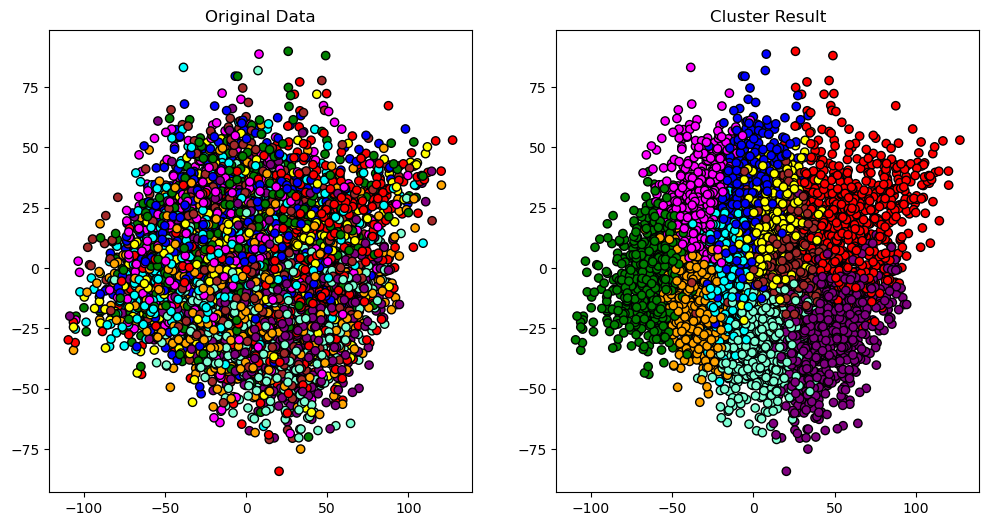

Train Time: 0.102164 s
Execution Time: 12.000308 s

Accuracy: 0.20825
Error Rate: 0.79175

Macro Precision_score: 0.2078710092595884
Micro Precision_score: 0.20825
Weighted Precision_score: 0.20782775416652655
Every Precision_score: [0.3        0.15862944 0.15815085 0.16307692 0.17158931 0.22276622
 0.18477044 0.12805588 0.34819277 0.24347826]

Macro Recall_score: 0.20846524299521
Micro Recall_score: 0.20825
Weighted Recall_score: 0.20825
Every Recall_score: [0.26525529 0.14740566 0.16645327 0.13659794 0.15061728 0.22807018
 0.20295203 0.13888889 0.35900621 0.28940568]

Confusion Matrix: [[213  52  36  22  15  31  31 179 132  92]
 [ 60 125  42  64  71  89  85  48  97 167]
 [ 78  73 130  85  48  60 140  99  30  38]
 [ 74  86 108 106 103 104  70  58  17  50]
 [ 35 107 109  84 122  82 143  57  23  48]
 [ 55  73 124  78 116 182  74  64   8  24]
 [ 61 140 110 141  80  58 165  39   7  12]
 [ 49  50  93  37  94 106 109 110  52  92]
 [ 38  30  17  22  41  56  18 121 289 173]
 [ 47  52  53  11 

In [19]:
Train_Result('KMeans', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

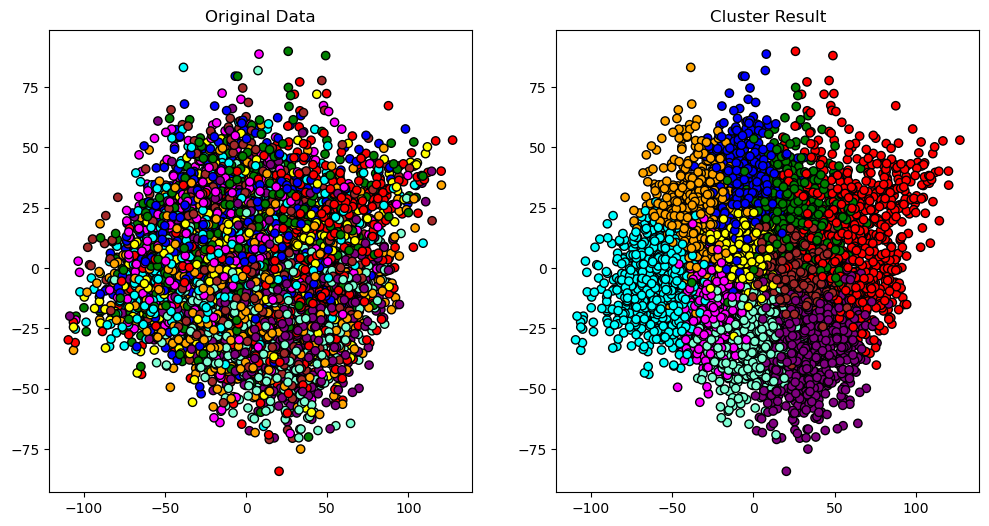

Train Time: 0.175178 s
Execution Time: 18.518731 s

Accuracy: 0.20125
Error Rate: 0.79875

Macro Precision_score: 0.19853742949409597
Micro Precision_score: 0.20125
Weighted Precision_score: 0.198442192677896
Every Precision_score: [0.32014388 0.11607143 0.16339869 0.0981241  0.14769976 0.22539683
 0.2148847  0.15589888 0.31390135 0.22985469]

Macro Recall_score: 0.20130032310158685
Micro Recall_score: 0.20125
Weighted Recall_score: 0.20125
Every Recall_score: [0.33250311 0.10731132 0.19206146 0.08762887 0.15061728 0.17794486
 0.25215252 0.14015152 0.34782609 0.2248062 ]

Confusion Matrix: [[267  26  36 107  38  14  39  80 132  64]
 [ 73  91  86  29  88  41 119  47 119 155]
 [ 81  47 150  96  92  49 113  87  31  35]
 [ 67 118  89  68  65  89 141  75  19  45]
 [ 41 123 126  65 122  86 129  54  27  37]
 [ 48 132 107  75  83 142  98  77   7  29]
 [ 37  85 146  74 152  45 205  48   5  16]
 [ 46  94  94  79  85  94  56 111  54  79]
 [118  46  36  69  22  34  27  50 280 123]
 [ 56  22  48  3

In [20]:
Train_Result('KMeans', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

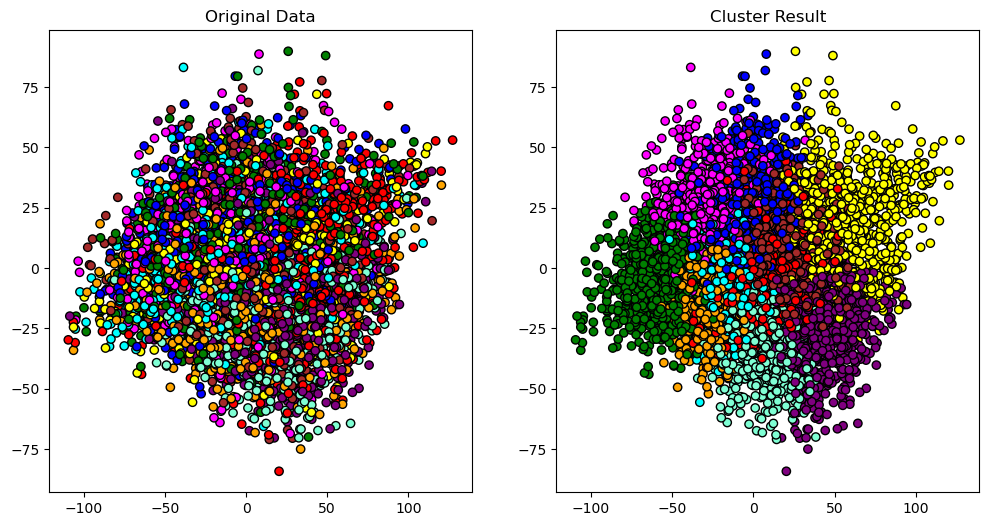

Train Time: 0.168739 s
Execution Time: 71.414342 s

Accuracy: 0.214
Error Rate: 0.786

Macro Precision_score: 0.21783533530532537
Micro Precision_score: 0.214
Weighted Precision_score: 0.21803391478024536
Every Precision_score: [0.24217687 0.20107962 0.12091898 0.15263749 0.20286086 0.26979866
 0.21559074 0.15336788 0.3298153  0.29010695]

Macro Recall_score: 0.21406489136049514
Micro Recall_score: 0.214
Weighted Recall_score: 0.214
Every Recall_score: [0.22166874 0.17570755 0.12804097 0.17525773 0.19259259 0.2518797
 0.21771218 0.18686869 0.31055901 0.28036176]

Confusion Matrix: [[178  46 221  35  15  25  30  57 132  64]
 [ 82 149  69  94  66  56  73  46  86 127]
 [ 42  68 100 106  62  54 122 158  32  37]
 [ 32  81  84 136  94 126  53 114  15  41]
 [ 36  72  47 121 156  75 130 107  25  41]
 [ 34  82  67  89 103 201  66 129   7  20]
 [ 13  88  60 198  92  55 177 114   5  11]
 [ 42  49  55  55 129  79  92 148  51  92]
 [206  46  70  34  20  46  11  24 250  98]
 [ 70  60  54  23  32  28

In [21]:
Train_Result('KMeans', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

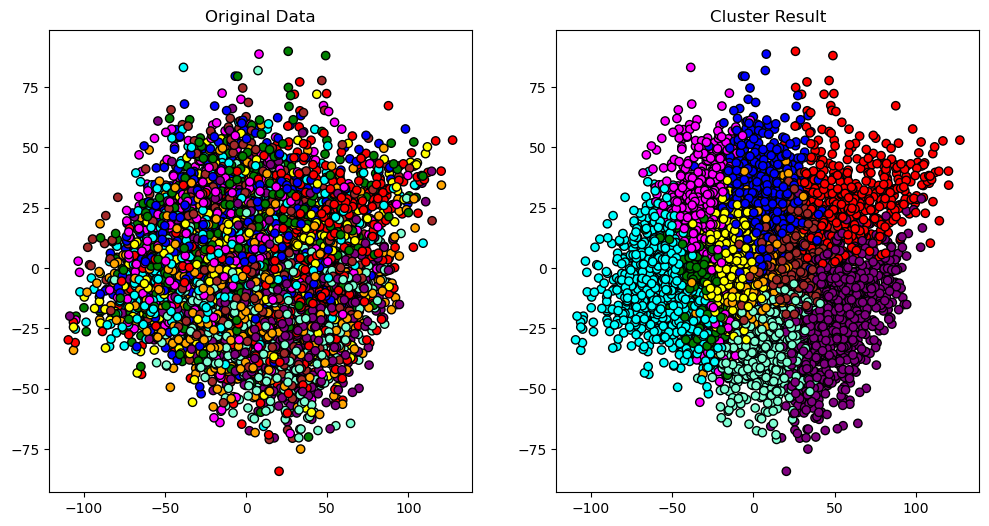

Train Time: 0.924857 s
Execution Time: 19.800449 s

Accuracy: 0.196125
Error Rate: 0.803875

Macro Precision_score: 0.19345863841565486
Micro Precision_score: 0.196125
Weighted Precision_score: 0.19322403362770857
Every Precision_score: [0.33783784 0.10229645 0.14625229 0.10860656 0.16513761 0.20434353
 0.19844358 0.13080685 0.28616684 0.25469484]

Macro Recall_score: 0.19668655880587718
Micro Recall_score: 0.196125
Weighted Recall_score: 0.196125
Every Recall_score: [0.21793275 0.05778302 0.20486556 0.06829897 0.15555556 0.2593985
 0.25092251 0.13510101 0.33664596 0.28036176]

Confusion Matrix: [[175 128  44  34  15  38  43  88 155  83]
 [ 17  49 127  80  77  51 118  51 135 143]
 [ 60  22 160  32  52 120 130 123  48  34]
 [ 63  14  98  53  96 141 152  85  28  46]
 [ 30  22 152  58 126 140 143  68  26  45]
 [ 49  13 128  51 114 207 111  92  14  19]
 [ 45   4 169  91  85 102 204  79  23  11]
 [ 41  36 114  36 117 135  56 107  57  93]
 [ 22 135  43  18  44  34  36  41 271 161]
 [ 16  56 

In [22]:
Train_Result('AC', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

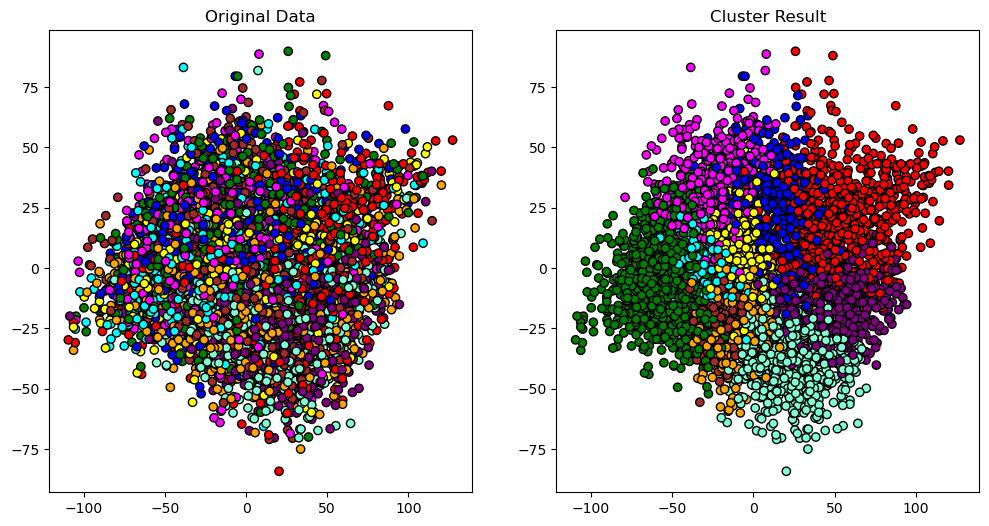

Train Time: 1.091403 s
Execution Time: 19.877844 s

Accuracy: 0.20275
Error Rate: 0.79725

Macro Precision_score: 0.19948297557490008
Micro Precision_score: 0.20275
Weighted Precision_score: 0.19955899936263047
Every Precision_score: [0.29326923 0.16360294 0.15019011 0.14701131 0.19431988 0.20112994
 0.23946037 0.12356322 0.2300406  0.25224215]

Macro Recall_score: 0.20360032498005398
Micro Recall_score: 0.20275
Weighted Recall_score: 0.20275
Every Recall_score: [0.37982565 0.10495283 0.20230474 0.23453608 0.16049383 0.22305764
 0.17466175 0.05429293 0.21118012 0.29069767]

Confusion Matrix: [[305  66  45  55  23  53  13  26 108 109]
 [ 75  89 107 146  68  37  55  55  93 123]
 [126  31 158 139  43 110  76  23  41  34]
 [ 94  27 105 182  89 121  55  35  33  35]
 [ 63  25 151 161 130  90  97  24  35  34]
 [ 79  24 124 135 115 178  66  37  25  15]
 [ 73  11 152 236  46  92 142  40  14   7]
 [ 79  58 115  90  97 105  51  43  86  68]
 [ 90 113  40  53  27  46   7  17 170 242]
 [ 56 100  55 

In [23]:
Train_Result('AC', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

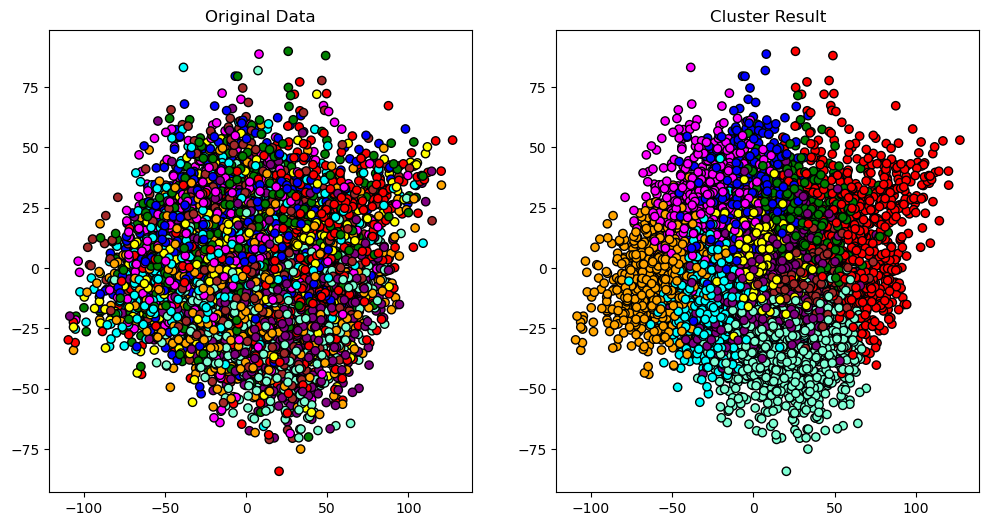

Train Time: 1.273531 s
Execution Time: 50.744769 s

Accuracy: 0.211375
Error Rate: 0.788625

Macro Precision_score: 0.20944064037330615
Micro Precision_score: 0.211375
Weighted Precision_score: 0.2090982814317607
Every Precision_score: [0.29364005 0.11616162 0.16872428 0.12978723 0.20665742 0.30715532
 0.20177778 0.18269231 0.23207547 0.25573492]

Macro Recall_score: 0.21161017994175063
Micro Recall_score: 0.211375
Weighted Recall_score: 0.211375
Every Recall_score: [0.27023661 0.13561321 0.1574904  0.07860825 0.18395062 0.22055138
 0.27921279 0.0959596  0.30559006 0.38888889]

Confusion Matrix: [[217  47  36  33  17  18  42  49 211 133]
 [ 65 115  38  30  79  40 123  39 138 181]
 [ 69 116 123  74  51  33 133  51  77  54]
 [ 60 142  65  61  88  97 110  35  76  42]
 [ 35 133 110  48 149  53 143  26  53  60]
 [ 55 103  89  49 102 176 111  31  59  23]
 [ 28 196 117  69  73  29 227  24  38  12]
 [ 37  71  90  66 105  66 120  76  59 102]
 [112  45   8  10  22  42  22  29 246 269]
 [ 61  22 

In [24]:
Train_Result('AC', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)